<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Scratch" data-toc-modified-id="Scratch-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Scratch</a></span></li></ul></div>

In [2]:
import pandas as pd
import numpy as np
import biom
import arviz as az
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib
from matplotlib_venn import venn2, venn3
from scipy.spatial.distance import euclidean
from scipy.stats import ttest_1samp
import seaborn as sns
%matplotlib inline

In [7]:
kegg_asd_WGS = pd.read_csv('../results/WGS_KEGG.csv')
kegg_asd_16S = pd.read_csv('../results/16S_KEGG.csv')
kegg_asd_RNA = pd.read_csv('../results/RNA_KEGG.csv')

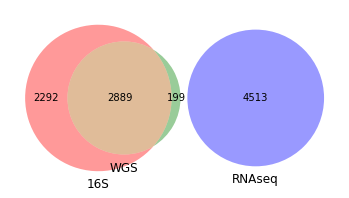

In [9]:
venn3([set(kegg_asd_16S['KEGG']), set(kegg_asd_WGS['KEGG']), set(kegg_asd_RNA['KEGG'])], 
      set_labels=['16S', 'WGS', 'RNAseq'])

# Scratch

In [3]:
sig_keggs = pd.read_csv('../results/WGS_16S_RNAseq_keggs.txt', sep='\t')

In [106]:
pwy2kegg = list()
with open('../results/pathway-to-ko.txt') as f:
    for line in f:
        toks = line.rstrip().split('\t')
        keggs = toks[1:]
        pwy = [toks[0]] * len(keggs)
        pk = list(zip(pwy, keggs))
        pwy2kegg += pk
pwy2kegg = pd.DataFrame(pwy2kegg, columns=['Pathway', 'KO'])
ko2pwy = pwy2kegg.set_index('KO')

ko2pwy2 = defaultdict(list)
for ko in pwy2kegg.KO.unique():
    ko2pwy2[ko] += list(ko2pwy.loc[ko].values.ravel().tolist())
    
ko2pwy = ko2pwy2

pwy_name = pd.read_table('../results/pathway_name.txt', header=None)
pwy_name.columns = ['Pathway', 'Name']
pwy2kegg = pd.merge(pwy2kegg, pwy_name, left_on='Pathway', right_on='Pathway')

Reshape 16S, shotgun and RNAseq datasets

In [107]:
sig_16S = sig_keggs[sig_keggs.TYPE == '16S']
sig_WGS = sig_keggs[sig_keggs.TYPE == 'Shotgun']
sig_RNA = sig_keggs[sig_keggs.TYPE == 'RNAseq']

sig_16S = pd.merge(pwy2kegg, sig_16S, left_on='KO', right_on='#KEGG').drop_duplicates()
sig_WGS = pd.merge(pwy2kegg, sig_WGS, left_on='KO', right_on='#KEGG').drop_duplicates()
sig_RNA = pd.merge(pwy2kegg, sig_RNA, left_on='KO', right_on='#KEGG').drop_duplicates()

sig_16S['count'] = 1
sig_WGS['count'] = 1
sig_RNA['count'] = 1

sig_16S = pd.pivot(sig_16S, index='Pathway', columns='KO', values='count').fillna(0)
sig_WGS = pd.pivot(sig_WGS, index='Pathway', columns='KO', values='count').fillna(0)
sig_RNA = pd.pivot(sig_RNA, index='Pathway', columns='KO', values='count').fillna(0)

In [108]:
lookup = {d: i for i, d in enumerate(pwy2kegg['Name'].value_counts().index)}
pwy2kegg['ID'] = pwy2kegg['Name'].apply(lambda x: lookup[x])
pwy2kegg = pwy2kegg.set_index('Pathway')

In [138]:
p2k.reset_index().groupby('Pathway').count()['KO'].sort_values()

Pathway
ko05165    231
ko05206    245
ko04151    263
ko05014    280
ko02024    282
ko05010    287
ko05022    368
ko05200    417
ko02020    495
ko02010    512
Name: KO, dtype: int64

Text(0.5, 69.0, 'KEGG IDs')

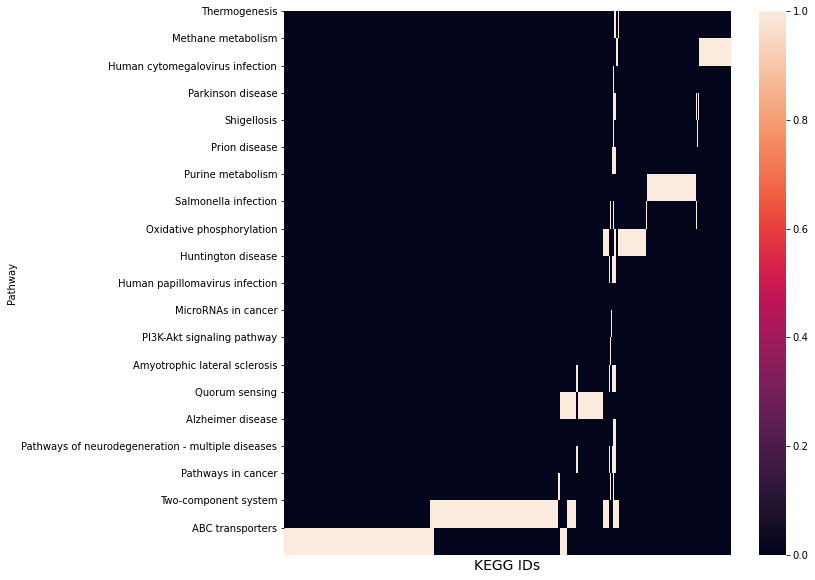

In [153]:
from gneiss.sort import mean_niche_estimator

# focus on most representative pathways
p2k = pwy2kegg.loc[sig_16S.index]
pwy_counts = p2k.reset_index().groupby('Pathway').count()['KO'].sort_values().tail(20)
sig_16S_ = sig_16S.loc[pwy_counts.index]
# Filter one-off genes
sig_16S_ = sig_16S_.loc[:, sig_16S.sum(axis=0) > 0]
# Match data structures
p2k = pwy2kegg.loc[sig_16S_.index]
labeled_kegg = p2k['ID'].drop_duplicates()
# Make it look more pretty
kegg_order = mean_niche_estimator(sig_16S_, labeled_kegg)
kegg_order = kegg_order.dropna()
kegg_order = kegg_order.sort_values()
sig_16S_ = sig_16S_.loc[:, kegg_order.index]

fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(sig_16S_, ax=ax)
pnames = p2k.loc[sig_16S_.index, 'Name'].drop_duplicates().values
_ = plt.yticks(np.arange(len(sig_16S_.index)), pnames)
plt.xticks([])
plt.xlabel('KEGG IDs', fontsize=14)